# Прогнозирование оттока пользователей провайдера телекоммуникационных услуг

## Республика Карелия. Региональный чемпионат

### 5 — 30 сентября 2022

## Задача

### Условие задачи

Участникам чемпионата предстоит создать свое решение по прогнозированию оттока с использованием данных о клиентах. В вашем
доступе находится информация о запросах пользователей к сайтам конкурентов и история обращений в компанию.

### Описание входных значений

    train.csv — файл содержащий данные пользователей для тренировки. Где:
        ○ 1 - клиент ушел,
        ○ 0 - остался.
    log.csv — содержит данные обращения пользователей.;
    named.csv — лог днс-запросов к доменам конкурентов (rt.ru и sampo.ru).
    type contract.csv - тип списания у пользователей, где:
        ○ 1 - посуточная,
        ○ 0 - помесячная.
    submission.csv — пример файла для отправки.

### Метрика
В качестве метрики выступает Recall по столбцу blocked.

## Загрузка библиотек и данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

%matplotlib inline

In [2]:
# df_train = pd.read_csv("/content/train.csv")
# df_sample_solution = pd.read_csv("/content/sample_solution.csv")

# df_named = pd.read_csv("/content/named.csv")
# df_type_contract = pd.read_csv("/content/type_contract.csv")
# df_log = pd.read_csv("/content/log.csv")

df_train = pd.read_csv("train.csv")
df_sample_solution = pd.read_csv("sample_solution_00.csv")

df_named = pd.read_csv("named.csv")
df_type_contract = pd.read_csv("type_contract.csv")
df_log = pd.read_csv("log.csv")

In [3]:
# EDA

def eda(df):
    """ функция выводит основные характеристики датафрейма """
    print(df.head())
    print('\n info()')
    print(df.info())
    print('\n describe()')
    print(df.describe())
    print('\n nunique()')
    print(df.nunique())

In [4]:
# котегории

from pandas.api.types import is_numeric_dtype
def get_categorical_indicies(X):
    """ функция принимает фрейм данных и возвращает индексы всех нечисловых столбцов в виде списка """
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

In [5]:
# Балансировка

def balans_01(df, field, plot = 0):
    """ функция принимает датафрейм df и возвращает датафрейм сбалансированный
    по минимальному значению поля field (значения 0/1) 
    Пример вызова df_train = balans_01(df_train,'blocked', plot = 1)"""
    df_0 = df[df[field]==0]    
    df_1 = df[df[field]==1]
    if len(df_0) < len(df_1):
        df_1 = df_1.sample(n=len(df_0), random_state=101)
    else:
        df_0 = df_0.sample(n=len(df_1), random_state=101)
    df = pd.concat([df_0,df_1],axis=0)
    
    if plot == 1:
        plt.pie(df[field].value_counts(), labels=[0, 1], colors=['wheat', 'chocolate'], explode=[0.1, 0.1], shadow=True)
        print(df.value_counts(field));
    
    return df

## Исследование данных

### df_train

In [6]:
eda(df_train)

   contract_id  blocked
0         7780        0
1         7785        0
2         7794        0
3         7795        0
4         7798        0

 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  5992 non-null   int64
 1   blocked      5992 non-null   int64
dtypes: int64(2)
memory usage: 93.8 KB
None

 describe()
         contract_id      blocked
count    5992.000000  5992.000000
mean    48867.505507     0.116489
std     49409.034843     0.320837
min      7780.000000     0.000000
25%     14988.500000     0.000000
50%     43939.500000     0.000000
75%     51186.750000     0.000000
max    274918.000000     1.000000

 nunique()
contract_id    5992
blocked           2
dtype: int64


In [7]:
df_train['blocked'].value_counts()

0    5294
1     698
Name: blocked, dtype: int64

blocked
0    5294
1     698
dtype: int64


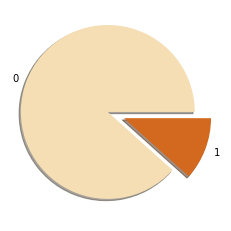

In [8]:
plt.pie(df_train['blocked'].value_counts(), labels=[0, 1], colors=['wheat', 'chocolate'], explode=[0.1, 0.1], shadow=True)
print(df_train.value_counts('blocked'));

array([[<AxesSubplot:title={'center':'contract_id'}>,
        <AxesSubplot:title={'center':'blocked'}>]], dtype=object)

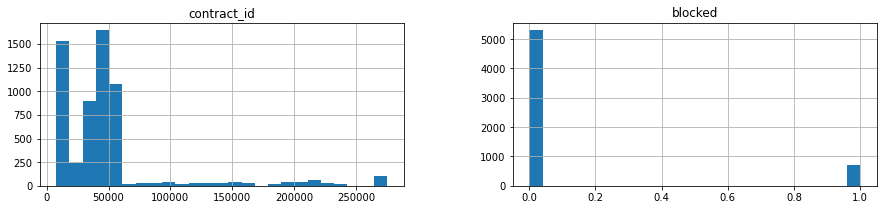

In [9]:
df_num = df_train.select_dtypes(include=['int8', 'int16','int32', 'int64'])
#df_num = df_train.select_dtypes(include=['float32','float64'])
df_num.hist(figsize=(15,3), bins=25, grid=True)

### df_named

In [10]:
eda(df_named)

          date                      url  contract_id
0  17-Apr-2021         webmail.sampo.ru       101397
1  17-Apr-2021         webmail.sampo.ru       179624
2  17-Apr-2021  tvip-provision.sampo.ru       190335
3  17-Apr-2021  tvip-provision.sampo.ru        61670
4  17-Apr-2021  tvip-provision.sampo.ru        39370

 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646537 entries, 0 to 10646536
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   date         object
 1   url          object
 2   contract_id  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ MB
None

 describe()
        contract_id
count  1.064654e+07
mean   1.093602e+05
std    5.722937e+04
min    3.455000e+03
25%    6.082400e+04
50%    1.098210e+05
75%    1.588340e+05
max    2.747860e+05

 nunique()
date               36
url              6583
contract_id    196148
dtype: int64


In [11]:
df_named['url'].value_counts()

camera.rt.ru                                         7333195
vmxott.svc.iptv.rt.ru                                 289876
tvip-provision.sampo.ru                               138944
webmail.sampo.ru                                      132718
statserv.sampo.ru                                     110428
                                                      ...   
_bittorrent-tracker._tcp.ip94-143-246-20.sampo.ru          1
_bittorrent-tracker._tcp.ip212-109-29-44.sampo.ru          1
jcyzowodsk.sampo.ru                                        1
dhmisszt.sampo.ru                                          1
broadband-90-154-70-112.ip.moscow.rt.ru                    1
Name: url, Length: 6583, dtype: int64

In [12]:
df_named[(df_named['contract_id'] >= 3453) & (df_named['contract_id'] <= 4262)] 

,date,url,contract_id
109,17-Apr-2021,swap.sampo.ru,3677
124,17-Apr-2021,www.sampo.ru,3845
125,17-Apr-2021,www.sampo.ru,3845
211,17-Apr-2021,swap.sampo.ru,3677
422,17-Apr-2021,swap.sampo.ru,3677
...,...,...,...
10640925,31-Mar-2021,fnc.rt.ru,4148
10643113,31-Mar-2021,isatap.sz.rt.ru,3998
10643151,31-Mar-2021,isatap.sz.rt.ru,3998
10643191,31-Mar-2021,isatap.sz.rt.ru,3998


In [13]:
len(df_named[(df_named['contract_id'] >= 3453) & (df_named['contract_id'] <= 4262)]['contract_id'].unique())

390

In [14]:
len(df_named[(df_named['contract_id'] >= 3453) & (df_named['contract_id'] <= 4262)]['url'].unique())

195

### df_type_contract

In [15]:
eda(df_type_contract)

   contract_id  day_or_month_contract
0         7780                      0
1         3996                      0
2         7785                      0
3         7794                      0
4         7795                      1

 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6805 entries, 0 to 6804
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   contract_id            6805 non-null   int64
 1   day_or_month_contract  6805 non-null   int64
dtypes: int64(2)
memory usage: 106.5 KB
None

 describe()
         contract_id  day_or_month_contract
count    6805.000000            6805.000000
mean    43493.714328               0.408964
std     48606.505607               0.491679
min      3453.000000               0.000000
25%     11474.000000               0.000000
50%     38499.000000               0.000000
75%     50495.000000               1.000000
max    274918.000000               1.000000

 n

array([[<AxesSubplot:title={'center':'contract_id'}>,
        <AxesSubplot:title={'center':'day_or_month_contract'}>]],
      dtype=object)

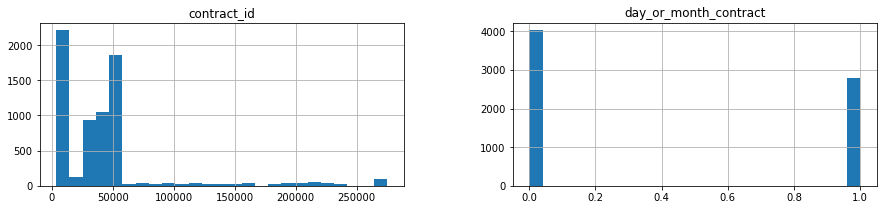

In [16]:
df_num = df_type_contract.select_dtypes(include=['int8', 'int16','int32', 'int64'])
df_num.hist(figsize=(15,3), bins=25, grid=True)

### df_log

In [17]:
eda(df_log)

   contract_id           event_date                            event_type
0        36294  2021-03-28 16:24:30     Добавление в Обращались с номеров
1        36294  2021-03-28 16:27:41  Обращение в службу заботы о клиентах
2        36294  2021-03-28 16:29:56                Выключение IPTV-пакета
3        36294  2021-03-28 16:29:56                 Включение IPTV-пакета
4        36294  2021-03-28 16:35:04  Обращение в службу заботы о клиентах

 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25274 entries, 0 to 25273
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   contract_id  25274 non-null  int64 
 1   event_date   25274 non-null  object
 2   event_type   25274 non-null  object
dtypes: int64(1), object(2)
memory usage: 592.5+ KB
None

 describe()
         contract_id
count   25274.000000
mean    50371.763314
std     55449.936583
min      3453.000000
25%     12158.500000
50%     43957.000000
75%     52039.000

In [18]:
df_log['event_type'].unique()

array(['Добавление в Обращались с номеров',
       'Обращение в службу заботы о клиентах', 'Выключение IPTV-пакета',
       'Включение IPTV-пакета', 'Отключение услуги Аренда ТВ-приставки',
       'Оборудование', 'Изменение истории', 'Продление действия тарифа',
       'Предложение IPTV', 'Активация точки подключения на сутки',
       'Смена тарифа', 'Удаление из Обращались с номеров', 'Смена пароля',
       'Предложение ТВ', 'Внутреннее сообщение', 'Операция с mac-адресом',
       'Закрепление сообщения', 'Перенос денежных средств',
       'Изменение данных клиента', 'Возвращение клиента',
       'Уведомления: подключение', 'Уведомления: подтверждение',
       'Состояние клиентского оборудования', 'Смена схемы оплаты',
       'Включена 20% скидка', 'Включение услуги Аренда ТВ-приставки',
       'Отключение скидки 20%', 'Предложение тарифа',
       'Активация гарантированного платежа',
       'Включение интернета на 20 минут',
       'Изменение контактных телефонов', 'Внесение', 'Смена

In [19]:
df_log.value_counts('event_type').head(30)

event_type
Информер ВК. Показ                                                  8001
Включение интернета на 20 минут                                     4092
Обращение в службу заботы о клиентах                                2860
Гарантированный платеж за деньги                                    2679
Виртуальное бессмертие. Использование                                757
Турбокнопка бесплатно                                                546
Включение интернета на 20 минут с IVR                                343
Смена тарифа                                                         335
Состояние клиентского оборудования                                   311
Смена пароля                                                         283
Оборудование                                                         276
Изменение истории                                                    220
Показ информатора об изменении уведомлений через ВК платформу        219
Предложение ТВ                          

In [20]:
df_log[(df_log['contract_id'] >= 3453) & (df_log['contract_id'] <= 4262)] 

,contract_id,event_date,event_type
1419,3639,2021-03-01 12:23:20,Активация гарантированного платежа
1420,3639,2021-03-01 12:23:28,Обращение в службу заботы о клиентах
1421,3639,2021-04-15 21:25:20,Реестр договоров
1422,3571,2021-03-15 09:53:54,Добавление в Обращались с номеров
1423,3571,2021-03-15 09:54:05,Обращение в службу заботы о клиентах
...,...,...,...
11141,4025,2021-03-30 02:37:59,Бонус-скорость
11142,4025,2021-04-16 16:20:02,Информер ВК. Показ
11143,4025,2021-04-16 16:20:09,Бонус-скорость
11144,4025,2021-04-29 19:33:28,Информер ВК. Показ


In [21]:
len(df_log[(df_log['contract_id'] >= 3453) & (df_log['contract_id'] <= 4262)]['contract_id'].unique())

502

### df_sample_solution

In [22]:
eda(df_sample_solution)

   contract_id  blocked
0         3453        0
1         3454        0
2         3455        0
3         3456        0
4         3457        0

 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  810 non-null    int64
 1   blocked      810 non-null    int64
dtypes: int64(2)
memory usage: 12.8 KB
None

 describe()
       contract_id  blocked
count   810.000000    810.0
mean   3857.500000      0.0
std     233.971152      0.0
min    3453.000000      0.0
25%    3655.250000      0.0
50%    3857.500000      0.0
75%    4059.750000      0.0
max    4262.000000      0.0

 nunique()
contract_id    810
blocked          1
dtype: int64


In [23]:
#  размерность наборов
print("df_train", df_train.shape)
print("df_named", df_named.shape)
print("df_type_contract", df_type_contract.shape)
print("df_log", df_log.shape)
print("df_sample_solution", df_sample_solution.shape)

df_train (5992, 2)
df_named (10646537, 3)
df_type_contract (6805, 2)
df_log (25274, 3)
df_sample_solution (810, 2)


## Подготовка данных

### train

Используем файлы df_train и df_log

In [24]:
train = df_train.copy()
train_id_min = train['contract_id'].min()
train_id_max = train['contract_id'].max()
train_id_min, train_id_max

(7780, 274918)

In [25]:
# Объединение df
train = pd.merge(df_log, train, how='left')
train.head(3)

,contract_id,event_date,event_type,blocked
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,1.0
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,1.0
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,1.0


In [26]:
train.sort_values('contract_id', ascending=True)

,contract_id,event_date,event_type,blocked
9275,3453,2021-03-03 16:18:58,Информер ВК. Показ,NaN
2248,3454,2021-04-28 11:28:42,Внутреннее сообщение,NaN
1727,3456,2021-03-21 19:15:50,Состояние клиентского оборудования,NaN
1728,3456,2021-03-21 19:15:50,Смена тарифа,NaN
1729,3456,2021-03-21 19:15:50,Внутреннее сообщение,NaN
...,...,...,...,...
1414,274786,2021-04-26 10:20:08,Обращение в службу заботы о клиентах,1.0
1415,274786,2021-04-28 19:26:41,Обращение в службу заботы о клиентах,1.0
1416,274786,2021-04-28 19:28:51,Обращение в службу заботы о клиентах,1.0
9146,274786,2021-04-26 10:08:26,Информер ВК. Показ,1.0


In [27]:
train.isna().sum()

contract_id       0
event_date        0
event_type        0
blocked        3037
dtype: int64

In [28]:
# Удаление NaN
train = train.dropna()
train['blocked'] = train['blocked'].astype(int)
train.blocked = train.blocked.astype(int)
train.head(3)

,contract_id,event_date,event_type,blocked
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,1
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,1
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,1


In [29]:
# Преобразование event_date to_datetime
train['date'] = pd.to_datetime(train['event_date'], dayfirst=True)
train = train.drop(columns= ['event_date'])
train = train.drop(columns= ['date'])

blocked
0    18714
1     3523
dtype: int64


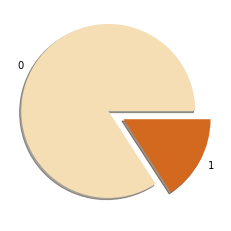

In [30]:
plt.pie(train['blocked'].value_counts(), labels=[0, 1], colors=['wheat', 'chocolate'], explode=[0.1, 0.1], shadow=True)
print(train.value_counts('blocked'));

blocked
0    3523
1    3523
dtype: int64


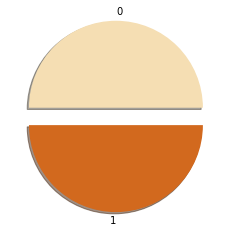

In [31]:
# Балансировка
train = balans_01(train,'blocked', plot = 1)

#### создание дополнительных признаков

In [32]:
# зависимость blocked от event_type
train_pv_ev = pd.pivot_table(train,index=["event_type"],columns=["blocked"],values=["blocked"],
               aggfunc={"contract_id":[np.count_nonzero]}, fill_value=0)
train_pv_ev

contract_id    
                                                   count_nonzero    
blocked                                                        0   1
event_type                                                          
Абонент оставил отзыв в Личном кабинете                        7  10
Активация ГП с IVR                                            12   9
Активация автоматического гарантированного платежа             1   2
Активация гарантированного платежа                            10  29
Активация точки подключения на сутки                           6  23
...                                                          ...  ..
Уведомления: отключение                                        2   0
Уведомления: подключение                                       2   1
Уведомления: подтверждение                                     2   1
Удаление из Обращались с номеров                               7  11
Удаление телефона из записи                                    2   4

[85 rows x 2 columns]

In [33]:
df_event_type = pd.DataFrame() 
df_event_type['bl_0'] = train_pv_ev['contract_id']['count_nonzero'][0] #оставшиеся
df_event_type['bl_1'] = train_pv_ev['contract_id']['count_nonzero'][1] #ушедшие
df_event_type['bl_d'] = 0   #разность
df_event_type['bl'] = 0     #признак

In [34]:
# если большинство сообщений у ушедших клиетов, то признак bl=1
for idx,row in df_event_type.iterrows():
    row['bl_d'] = row['bl_1'] - row['bl_0']
    if row['bl_1'] > row['bl_0']:
        row['bl'] = 1
df_event_type 

,bl_0,bl_1,bl_d,bl
event_type,,,,
Абонент оставил отзыв в Личном кабинете,7,10,3,1
Активация ГП с IVR,12,9,-3,0
Активация автоматического гарантированного платежа,1,2,1,1
Активация гарантированного платежа,10,29,19,1
Активация точки подключения на сутки,6,23,17,1
...,...,...,...,...
Уведомления: отключение,2,0,-2,0
Уведомления: подключение,2,1,-1,0
Уведомления: подтверждение,2,1,-1,0


In [35]:
df_event_type = df_event_type.drop(columns= ['bl_0', 'bl_1', 'bl_d'])
#df_event_type

In [36]:
# Объединение df
train = pd.merge(train, df_event_type, how='left', left_on='event_type', right_on='event_type')
train.head()

,contract_id,event_type,blocked,bl
0,13525,Информер ВК. Показ,0,0
1,49824,Состояние клиентского оборудования,0,1
2,31085,Включение интернета на 20 минут,0,0
3,49469,Информер ВК. Показ,0,0
4,52196,Гарантированный платеж за деньги,0,0


In [37]:
eda(train)

   contract_id                          event_type  blocked  bl
0        13525                  Информер ВК. Показ        0   0
1        49824  Состояние клиентского оборудования        0   1
2        31085     Включение интернета на 20 минут        0   0
3        49469                  Информер ВК. Показ        0   0
4        52196    Гарантированный платеж за деньги        0   0

 info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7046 entries, 0 to 7045
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   contract_id  7046 non-null   int64 
 1   event_type   7046 non-null   object
 2   blocked      7046 non-null   int32 
 3   bl           7046 non-null   int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 247.7+ KB
None

 describe()
         contract_id      blocked           bl
count    7046.000000  7046.000000  7046.000000
mean   100405.808970     0.500000     0.386886
std     81247.345873     0.500035 

### test

In [38]:
test = df_sample_solution.copy()
test_id_min = df_sample_solution['contract_id'].min()
test_id_max = df_sample_solution['contract_id'].max()
test_id_min, test_id_max

(3453, 4262)

In [39]:
test = pd.merge(df_log, test, how='left')
test.head(3)

,contract_id,event_date,event_type,blocked
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,NaN
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,NaN
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,NaN


In [40]:
#test.sort_values('contract_id', ascending=True)

In [41]:
test = test.dropna()

In [42]:
# Преобразование event_date to_datetime
test['date'] = pd.to_datetime(test['event_date'])
test = test.drop(columns= ['event_date'])
test = test.drop(columns= ['date'])

In [43]:
test = pd.merge(test, df_event_type, how='left', left_on='event_type', right_on='event_type')
test.head()

,contract_id,event_type,blocked,bl
0,3639,Активация гарантированного платежа,0.0,1.0
1,3639,Обращение в службу заботы о клиентах,0.0,1.0
2,3639,Реестр договоров,0.0,0.0
3,3571,Добавление в Обращались с номеров,0.0,1.0
4,3571,Обращение в службу заботы о клиентах,0.0,1.0


In [44]:
test.isna().sum()

contract_id     0
event_type      0
blocked         0
bl             57
dtype: int64

In [45]:
test['bl'] = test['bl'].fillna(0)

In [46]:
test = test.drop(columns= ['blocked'])

In [47]:
eda(test)

   contract_id                            event_type   bl
0         3639    Активация гарантированного платежа  1.0
1         3639  Обращение в службу заботы о клиентах  1.0
2         3639                      Реестр договоров  0.0
3         3571     Добавление в Обращались с номеров  1.0
4         3571  Обращение в службу заботы о клиентах  1.0

 info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3037 entries, 0 to 3036
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   contract_id  3037 non-null   int64  
 1   event_type   3037 non-null   object 
 2   bl           3037 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 94.9+ KB
None

 describe()
       contract_id           bl
count  3037.000000  3037.000000
mean   3845.250905     0.312479
std     237.850494     0.463580
min    3453.000000     0.000000
25%    3628.000000     0.000000
50%    3857.000000     0.000000
75%    4048.000000    

## Построение модели 

In [48]:
from sklearn.model_selection import train_test_split

X = train.drop(columns= ['blocked'])
y = train['blocked']

x_train, x_val, y_train, y_val = train_test_split(X, y ,stratify= y, test_size=.2, random_state=8)
print(train.blocked.value_counts())
y_train.sum(), y_val.sum()

0    3523
1    3523
Name: blocked, dtype: int64


(2818, 705)

In [49]:
#Создание объекта данных Pool, плюсы: возможность указать какие признаки являются категориальными
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
from sklearn.metrics import r2_score
pool_train = Pool(x_train, y_train, cat_features = ['event_type'])
pool_val = Pool(x_val, cat_features = ['event_type'])

In [50]:
#Объявление CatBoostRegressor и обучение

model = CatBoostRegressor(depth = 6, iterations = 1000)
model.fit(pool_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
#Получение ответов модели на тестовой выборке в локальном тестировании 
y_pred = model.predict(pool_val)

In [52]:
from sklearn.metrics import r2_score
#На локальном тестировании модель выдаёт такой результат
print("Значение метрики R2 на test: ", r2_score(y_val, y_pred))

Значение метрики R2 на test:  0.9151312706914351


In [53]:
#Получение ответов

pool_test_solution = Pool(test, cat_features = ['event_type'])
y_pred_solution = model.predict(pool_test_solution)
#y_pred_solution

In [54]:
y_pred_sol = y_pred_solution + 1
y_pred_sol

array([0.93702536, 1.01235211, 0.98351764, ..., 0.98290548, 1.00165383,
       0.98290548])

In [55]:
test['predict'] = y_pred_sol.astype(int)
test.head()

,contract_id,event_type,bl,predict
0,3639,Активация гарантированного платежа,1.0,0
1,3639,Обращение в службу заботы о клиентах,1.0,1
2,3639,Реестр договоров,0.0,0
3,3571,Добавление в Обращались с номеров,1.0,1
4,3571,Обращение в службу заботы о клиентах,1.0,1


In [56]:
s_count = test.groupby('contract_id').count()
#s_count

In [57]:
s_sum = test.groupby('contract_id').sum()
#s_sum

In [58]:
#test.groupby(['contract_id','event_type']).sum().sort_values('predict', ascending=False)

In [59]:
result = df_sample_solution.copy()

for idx,row in s_sum.iterrows():
    #if s_count.loc[idx]['event'] > 2 : 
    #if s_sum.loc[idx]['predict'] > 0:  
    if s_sum.loc[idx]['bl'] > 0 and s_sum.loc[idx]['predict'] > 0:   
        bl = 1
    else:
        bl = 0
    result.loc[result['contract_id'] == idx,'blocked'] = bl 
    
result

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,1
4,3457,0
...,...,...
805,4258,0
806,4259,0
807,4260,0
808,4261,1


In [60]:
res_str = str(result['blocked'].sum())
res_str

'225'

In [61]:
#Сохраняем в csv файл
 
result.to_csv('220925_43 ' + res_str + ' submission.csv', index=None)
result.to_csv('submission.csv', index=None)